### Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, classification_report
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from pdpbox import pdp, info_plots
from IPython.display import display
from sklearn.neural_network import MLPClassifier
from sklearn.base import clone
from tabulate import tabulate
import shap

### Import data

In [2]:
file_path = "https://raw.githubusercontent.com/sarahvastani/newrepo/refs/heads/main/unnormalized%20-%20motusSurvivalPhenotypes.20240916.csv"
df = pd.read_csv(file_path)
df = df.drop(df.columns[0], axis=1)
df.head()

,sex_binary,aims_ancestry,aims_heterozygosity,tarsus.length,tail.length,wing.cord,kipps,distal,p10,bodyCondition,releaseDay,fall_detectDay1,fall_bearing1,t5_spring40
0,1,0.136428,0.186393,28.7,71.0,99.0,29.6,NaN,NaN,1.306620,228.0,NaN,NaN,0.0
1,1,0.422082,0.620545,28.5,69.0,100.0,32.7,NaN,NaN,1.203509,229.0,250.0,130.888594,0.0
2,1,0.509015,0.707351,27.4,66.0,95.0,30.1,NaN,NaN,1.010949,233.0,260.0,174.492173,0.0
3,1,0.289157,0.447909,28.0,68.0,99.0,30.7,NaN,NaN,1.142857,233.0,NaN,NaN,0.0
4,1,0.383090,0.170494,29.8,67.0,96.0,29.7,NaN,NaN,0.979866,233.0,262.0,189.398267,0.0


### KNN imputation

In [4]:
n_neighbors = 5 
knn_imputer = KNNImputer(n_neighbors=n_neighbors)
df = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns)
df.isna().sum()

sex_binary             0
aims_ancestry          0
aims_heterozygosity    0
tarsus.length          0
tail.length            0
wing.cord              0
kipps                  0
distal                 0
p10                    0
bodyCondition          0
releaseDay             0
fall_detectDay1        0
fall_bearing1          0
t5_spring40            0
dtype: int64

In [5]:
df.head()

,sex_binary,aims_ancestry,aims_heterozygosity,tarsus.length,tail.length,wing.cord,kipps,distal,p10,bodyCondition,releaseDay,fall_detectDay1,fall_bearing1,t5_spring40
0,1.0,0.136428,0.186393,28.7,71.0,99.0,29.6,60.52,16.0,1.306620,228.0,252.8,145.746455,0.0
1,1.0,0.422082,0.620545,28.5,69.0,100.0,32.7,61.04,15.6,1.203509,229.0,250.0,130.888594,0.0
2,1.0,0.509015,0.707351,27.4,66.0,95.0,30.1,58.30,16.2,1.010949,233.0,260.0,174.492173,0.0
3,1.0,0.289157,0.447909,28.0,68.0,99.0,30.7,60.64,15.8,1.142857,233.0,255.6,155.082488,0.0
4,1.0,0.383090,0.170494,29.8,67.0,96.0,29.7,58.16,16.2,0.979866,233.0,262.0,189.398267,0.0


### Set up feature columns (X) and target variable (y)

In [7]:
features = ['fall_detectDay1', 'fall_bearing1',
            'distal', 'p10', 'bodyCondition', 'tarsus.length',
            'kipps', 'tail.length', 'wing.cord', 
            'sex_binary', 'releaseDay', 'aims_heterozygosity', 
            'aims_ancestry']

X = df[features]
y = df['t5_spring40']
y = y.astype(int) 

#### SMOTE (Synthetic Minority Over-sampling Technique)

In [8]:
smote = SMOTE(random_state=1)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=1)

### Hyperparameter tuning

In [9]:
param_grid = {
    'hidden_layer_sizes': [(64,), (64, 32), (128, 64), (128, 64, 32)],  
    'activation': ['relu', 'tanh', 'logistic'],  
    'solver': ['adam', 'sgd'], 
    'alpha': [0.0001, 0.001, 0.01],  
    'learning_rate': ['constant', 'adaptive'],  
    'learning_rate_init': [0.001, 0.01, 0.1],  
    'max_iter': [500, 1000]  
}

mlp = MLPClassifier(random_state=1)

grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Best Parameters: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (64,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 500, 'solver': 'adam'}
Best Score: 0.5888888888888889
              precision    recall  f1-score   support

           0       0.57      0.59      0.58       111
           1       0.61      0.60      0.60       121

    accuracy                           0.59       232
   macro avg       0.59      0.59      0.59       232
weighted avg       0.59      0.59      0.59       232



### Updated model and confusion matrix

[[65 46]
 [49 72]]
              precision    recall  f1-score   support

           0       0.57      0.59      0.58       111
           1       0.61      0.60      0.60       121

    accuracy                           0.59       232
   macro avg       0.59      0.59      0.59       232
weighted avg       0.59      0.59      0.59       232



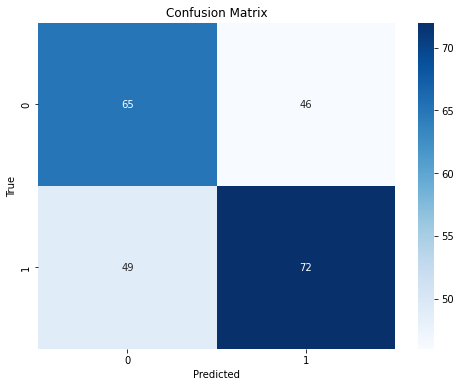

In [11]:
model = MLPClassifier(hidden_layer_sizes=(64,), activation='tanh', solver='adam', alpha=0.0001, learning_rate='constant', learning_rate_init=0.001,  
                      max_iter=500, random_state=1)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Permutation importance

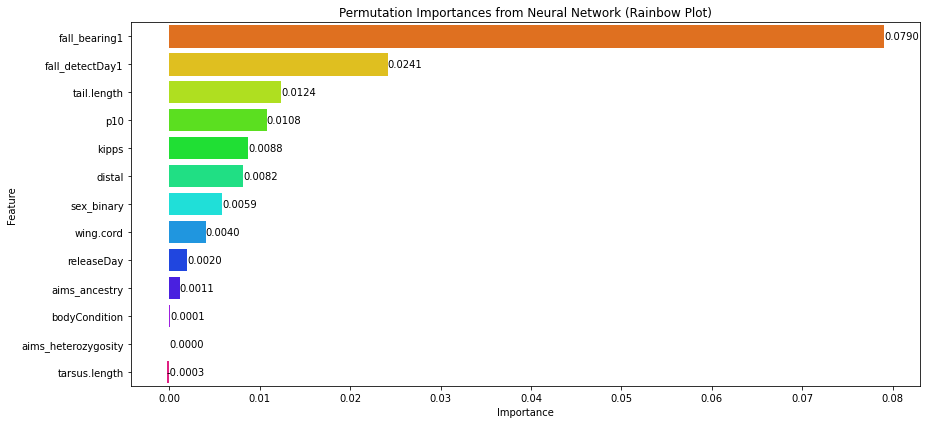

                Feature  Importance
1         fall_bearing1    0.079023
0       fall_detectDay1    0.024138
7           tail.length    0.012356
3                   p10    0.010776
6                 kipps    0.008764
2                distal    0.008190
9            sex_binary    0.005891
8             wing.cord    0.004023
10           releaseDay    0.002011
12        aims_ancestry    0.001149
4         bodyCondition    0.000144
11  aims_heterozygosity    0.000000
5         tarsus.length   -0.000287


In [12]:
def plot_rainbow_permutation_importance(model, X_test, y_test):
    results = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=1)

    feature_importances = pd.DataFrame({
        'Feature': X_test.columns,
        'Importance': results.importances_mean
    })

    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

    num_features = feature_importances.shape[0]
    colors = sns.color_palette("hsv", num_features)

    plt.figure(figsize=(13, 6))
    ax = sns.barplot(
        x='Importance', 
        y='Feature', 
        data=feature_importances, 
        palette=colors
    )
    plt.title('Permutation Importances from Neural Network (Rainbow Plot)')

    for index, value in enumerate(feature_importances['Importance']):
        ax.text(value, index, f'{value:.4f}', va='center', color='black')

    plt.tight_layout()
    plt.show()

    return feature_importances

permutation_importance_df = plot_rainbow_permutation_importance(model, X_test, y_test)

print(permutation_importance_df)

### Interaction Importance

In [13]:
def compute_pairwise_interaction_importance(model, X, y, features):
    interaction_importance = pd.DataFrame(columns=['feature_1', 'feature_2', 'importance'])

    baseline_model = clone(model)
    baseline_model.fit(X, y)
    baseline_score = accuracy_score(y, baseline_model.predict(X))

    for i in range(len(features)):
        for j in range(i + 1, len(features)):
            X_interaction = X.copy()

            interaction_feature = X_interaction[features[i]] * X_interaction[features[j]]
            X_interaction[features[i] + '_x_' + features[j]] = interaction_feature

            model_clone = clone(model)
            model_clone.fit(X_interaction, y)

            result = permutation_importance(model_clone, X_interaction, y, n_repeats=30, random_state=1, n_jobs=-1)
            importance_value = result.importances_mean[-1]  

            new_row = pd.DataFrame({
                'feature_1': [features[i]],
                'feature_2': [features[j]],
                'importance': [importance_value]
            })
            interaction_importance = pd.concat([interaction_importance, new_row], ignore_index=True)

    total_importance = interaction_importance['importance'].sum()
    interaction_importance['importance'] = interaction_importance['importance'] / total_importance if total_importance > 0 else 0

    return interaction_importance.sort_values(by='importance', ascending=False)

interaction_importance_df = compute_pairwise_interaction_importance(model, X_train, y_train, features)

print(tabulate(interaction_importance_df, headers='keys', tablefmt='pretty', showindex=False))

+---------------------+---------------------+-------------------------+
|      feature_1      |      feature_2      |       importance        |
+---------------------+---------------------+-------------------------+
|    fall_bearing1    |     sex_binary      |   0.05223867580625468   |
|    fall_bearing1    |    aims_ancestry    |   0.04519212321001865   |
|   fall_detectDay1   | aims_heterozygosity |   0.04322118151849718   |
|   fall_detectDay1   |     sex_binary      |   0.04255838696736611   |
|       distal        | aims_heterozygosity |  0.041215355903231984   |
|   fall_detectDay1   |    aims_ancestry    |  0.039017668707376225   |
|     releaseDay      |    aims_ancestry    |   0.03807580276629516   |
|     releaseDay      | aims_heterozygosity |   0.03751765998639527   |
|      wing.cord      |     sex_binary      |  0.036401374426595516   |
|     sex_binary      |     releaseDay      |   0.03484903981999896   |
|      wing.cord      |    aims_ancestry    |   0.03425601311635

In [23]:
interaction_importance_df.to_csv('nn_interaction_importance_unnorm.csv', index=False)

### SHAP

Using 488 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/488 [00:00<?, ?it/s]

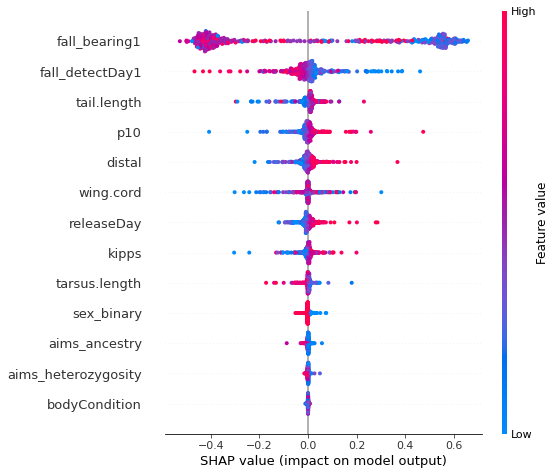

In [15]:
explainer = shap.KernelExplainer(model.predict, X)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)

In [16]:
import numpy as np

# Save SHAP values
np.save('shap_values.npy', shap_values)

In [17]:
# Load SHAP values
shap_values = np.load('shap_values.npy', allow_pickle=True)

In [18]:
import pickle

# Save the explainer
with open('explainer.pkl', 'wb') as file:
    pickle.dump(explainer, file)


In [19]:
# Load the explainer
with open('explainer.pkl', 'rb') as file:
    explainer = pickle.load(file)


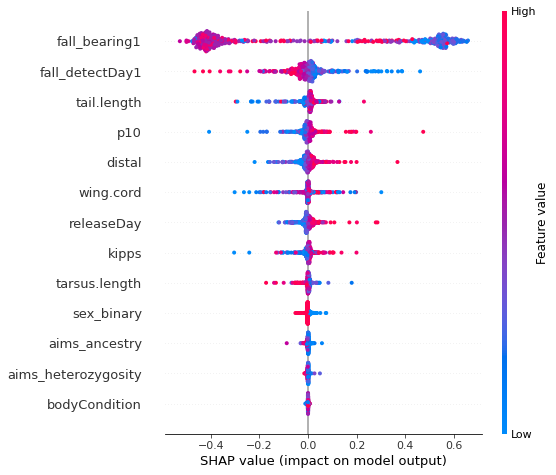

In [20]:
import os
import numpy as np
import shap
import pickle

if os.path.exists('shap_values.npy') and os.path.exists('explainer.pkl'):
    # Load saved SHAP values and explainer
    shap_values = np.load('shap_values.npy', allow_pickle=True)
    with open('explainer.pkl', 'rb') as file:
        explainer = pickle.load(file)
else:
    # Compute SHAP values
    explainer = shap.KernelExplainer(model.predict, X)
    shap_values = explainer.shap_values(X)
    
    # Save SHAP values and explainer for future use
    np.save('shap_values.npy', shap_values)
    with open('explainer.pkl', 'wb') as file:
        pickle.dump(explainer, file)

# Create SHAP summary plot
shap.summary_plot(shap_values, X)


In [21]:
# Create summary
shap_summary_nn = pd.DataFrame({
    'Trait': X.columns,
    'SHAP_NN_Mean': shap_values.mean(axis=0),
    'SHAP_NN_Std': shap_values.std(axis=0)
})

# Save to CSV
shap_summary_nn.to_csv('shap_nn_summary.csv', index=False)


### SHAP dependence plots

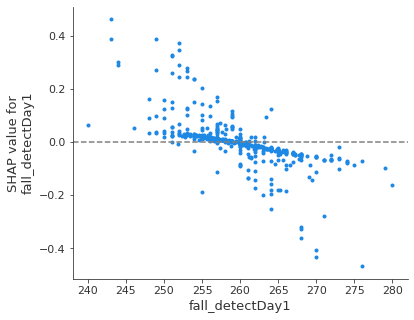

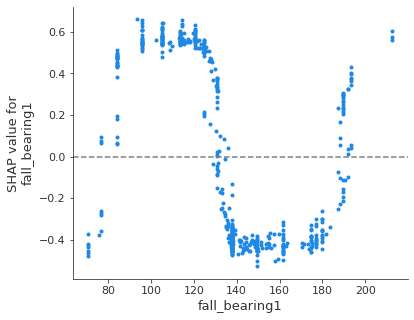

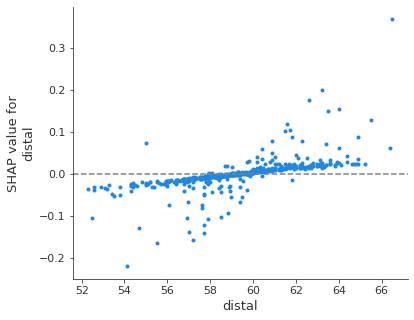

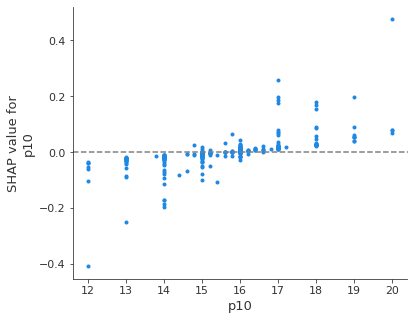

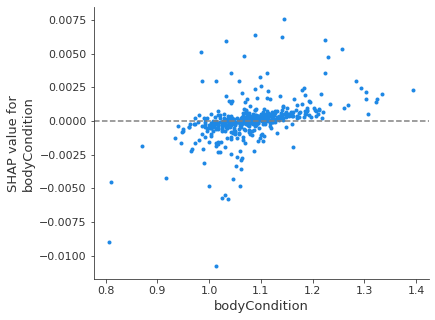

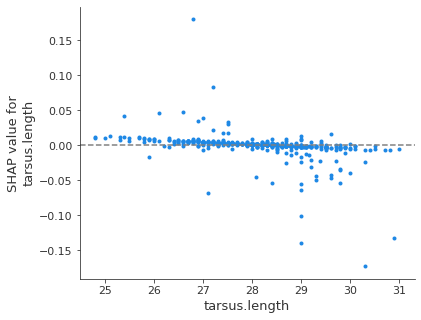

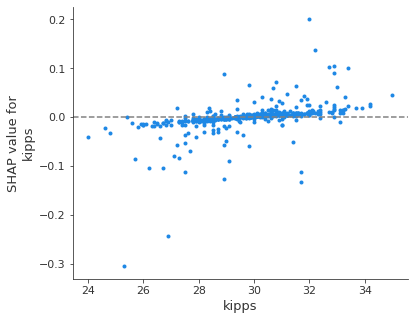

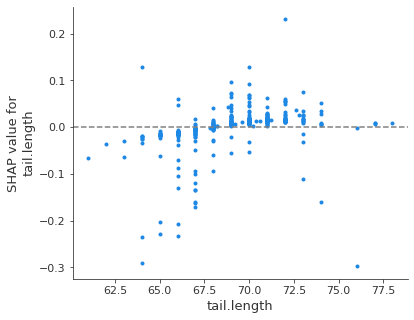

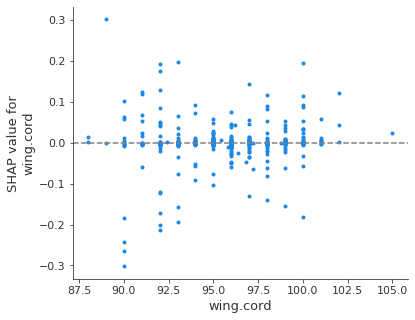

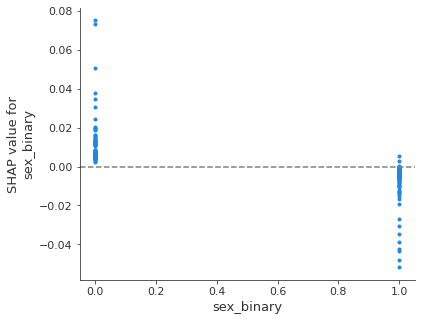

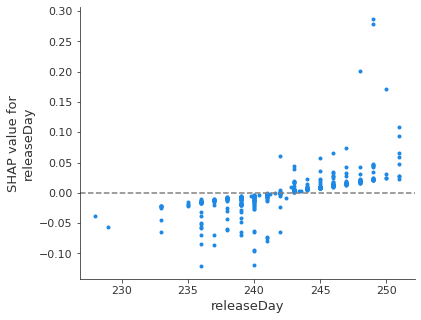

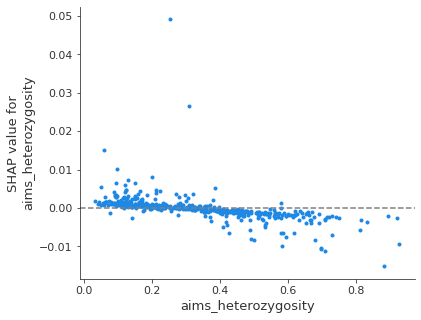

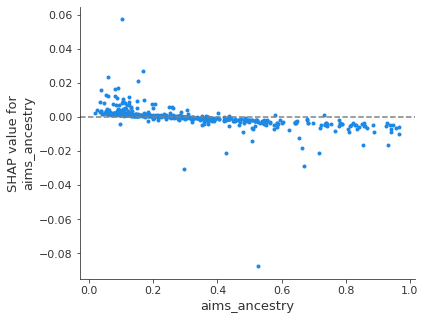

In [22]:
for feature in features:
    shap.dependence_plot(feature, shap_values, X, interaction_index=None, show=False)  
    
    plt.axhline(y=0, color='gray', linestyle='--') 
    
    plt.show()